In [1]:
import sys
import os
sys.path.append("../src/")
import combat
import numpy as np
import scipy.stats as stats
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import sklearn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sb
import pickle as pkl
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, ElasticNet,LinearRegression
import random as rd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 500
from sklearn.preprocessing import quantile_transform,binarize
from sklearn.model_selection import LeaveOneOut,KFold
from sklearn.metrics import r2_score
from statsmodels.stats.multitest import multipletests
from sklearn.cross_decomposition import PLSRegression as PLS
import warnings
warnings.simplefilter("ignore")
from multiprocessing import Process,Queue,Pool
import time 
import helper
from multiprocessing import set_start_method
#set_start_method("spawn")
from DecoID.DecoID import flatten
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVC
import importlib
import helper#import the module here, so that it can be reloaded.
importlib.reload(helper)
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multitest import multipletests
from copy import deepcopy
from collections import namedtuple
from scipy import special


def welch_anova_np(*args, var_equal=False):
    # https://svn.r-project.org/R/trunk/src/library/stats/R/oneway.test.R
    # translated from R Welch ANOVA (not assuming equal variance)

    F_onewayResult = namedtuple('F_onewayResult', ('statistic', 'pvalue'))

    args = [np.asarray(arg, dtype=float) for arg in args]
    k = len(args)
    ni =np.array([len(arg) for arg in args])
    mi =np.array([np.mean(arg) for arg in args])
    vi =np.array([np.var(arg,ddof=1) for arg in args])
    wi = ni/vi

    tmp =sum((1-wi/sum(wi))**2 / (ni-1))
    tmp /= (k**2 -1)

    dfbn = k - 1
    dfwn = 1 / (3 * tmp)

    m = sum(mi*wi) / sum(wi)
    f = sum(wi * (mi - m)**2) /((dfbn) * (1 + 2 * (dfbn - 1) * tmp))
    prob = special.fdtrc(dfbn, dfwn, f)   # equivalent to stats.f.sf
    return F_onewayResult(f, prob)

In [2]:
#load in metadata and peak areas and associate

#read in peak data
datafilename = "../data/QTof-B1-9_pHILIC_HSS_pos-neg_normalized.csv"
data = pd.read_csv(datafilename)

#get area columns
areaCols = data.columns.values[10:]

#get molecule names
mol_names = data["Compound Name"].values

#extract area data and transpose
areaData = data[areaCols].transpose()

#get batch information
batchInfo = [int(x.split("_")[0][1]) for x in list(areaData.index.values)]

areaData = areaData.to_numpy()
areaData = areaData.astype(np.float)

#get index of blanks
blankSamp = [x for x in range(len(areaCols)) if "Blank" in areaCols[x] and not "equil" in areaCols[x]]
print(len(blankSamp)," blanks")

#get index of qc
qcSamp = [x for x in range(len(areaCols)) if "NIST" in areaCols[x] and not "equil" in areaCols[x] ]
print(len(qcSamp)," qc samples")

#get index of wu350 samples
samp = [x for x in range(len(areaCols)) if "WU350" in areaCols[x] and not "equil" in areaCols[x]]
print(len(samp), "research samples")

#load in metadata
metadatafn = "../data/Experiment-Parameters_b1-9.csv"
metadata = pd.read_csv(metadatafn)

#extact sample names for d0_yes samples
metadata_rel = metadata[(metadata["day-COVID"] == "d0_Yes") | (metadata["day-COVID"] == "d0_No")]
print(len(metadata_rel)," d0 Samples")

            
#create sample name, ventilator status linkage
vent_dict = {}
metadata_dict = {}
for index,row in metadata_rel.iterrows():
    val = str(row["ICU"])
    sampName = row["Sample General Name"]
    if row["day-COVID"] == "d0_No":
        val = -1
    else:
        if "es" in val:
            val = 1
        elif "o" in val:
            val = 0
    vent_dict[sampName] = val
    metadata_dict[sampName] = row

print(np.sum(list(vent_dict.values()))," ICU+ samples")
print(len(vent_dict) - np.sum(list(vent_dict.values())),"ICU- samples")

#link vent status to sample in peak data
vent_status = []
metadata_for_samples = []
patient_ids = []

for s in np.array(areaCols)[samp]:
    tmp = s
    if tmp in vent_dict:
        vent_status.append(vent_dict[tmp])
        metadata_for_samples.append(metadata_dict[tmp])
        patient_ids.append(metadata_dict[tmp]["WU-350"])

    else:
        vent_status.append(-2)
        metadata_for_samples.append(-2)
        patient_ids.append(-2)



print("found vent info for",len([x for x in vent_status if x != -2]),"covid_ d0 samples")
samplesOfInterest = [x for x in range(len(vent_status)) if vent_status[x] != -2]
ICU_vals = np.array([x for x in vent_status if x != -2])

patient_ids = np.array(patient_ids)[samplesOfInterest]
#create sample matrix
samp_int = np.log2(areaData[samp][samplesOfInterest])
metadata_for_samples = [metadata_for_samples[x] for x in samplesOfInterest]

patient_ICU = {id:stat for id,stat in zip(patient_ids,ICU_vals)}
patient_ind = {id:i for id,i in zip(patient_ids,range(len(patient_ids)))}

var_imp = pd.read_csv("../data/var_importance_final.csv",index_col=0)

vars_of_interest = []
for x in var_imp.index.values:
    index = 0
    for y in mol_names:
        if x == y:
            vars_of_interest.append(index)
            break
        index += 1 
        
samp_int = samp_int[:,vars_of_interest]
mol_names = var_imp["plot-name"].values

print(samp_int.shape)
var_imp

0  blanks
0  qc samples
704 research samples
323  d0 Samples
64  ICU+ samples
259 ICU- samples
found vent info for 322 covid_ d0 samples
(322, 25)


,var_imp,plot-name
HSSneg_LPE 18:0@7.653,-0.001013,LPE 18:0
HSSpos_Cer_NS d18:1_16:0_17.788,0.001118,Cer-NS d18:1_16:0
HSSpos_Cer_NS d18:2_16:0_16.67,0.000905,Cer-NS d18:2_16:0
HSSpos_LPC 0:0/16:0_4.715,-0.000702,LPC 0:0/16:0
HSSpos_LPC 0:0/18:0_6.997,-0.001206,LPC 0:0/18:0
HSSpos_LPC 14:0/0:0_3.387,-0.000405,LPC 14:0/0:0
HSSpos_LPC 15:0/0:0_4.164,-0.000155,LPC 15:0/0:0
HSSpos_LPC 16:0/0:0_5.147,-0.000232,LPC 16:0/0:0
HSSpos_LPC 16:1/0:0_3.734,0.000187,LPC 16:1/0:0
HSSpos_LPC 17:0/0:0_6.28,-0.000472,LPC 17:0/0:0


7.565359477124183 11.304055725763579 306
-0.6 3.713196209057168 115
6.226086956521739 7.6306713700470645 115
[11.0, 3.0, 15.0, 2.0, 2.0, 4.0, 0.0, 10.0, 7.0, 8.0, 6.0, 3.0, 3.0, 7.0, 10.0, 5.0, 2.0, 6.0, 4.0, 7.0, 7.0, 4.0, 1.0, 11.0, 2.0, 14.0, 2.0, 4.0, 7.0, 6.0, 2.0, 4.0, 7.0, 3.0, 2.0, 6.0, 10.0, 4.0, 3.0, 31.0, 1.0, 14.0, 7.0, 5.0, 4.0, 3.0, 2.0, 1.0, 4.0, 0.0, 5.0, 16.0, 3.0, 2.0, 11.0, 2.0, 3.0, 8.0, 3.0, 7.0, 2.0, 10.0, 2.0, 2.0, 2.0, 2.0, 14.0, 7.0, 1.0, 2.0, 4.0, 8.0, 14.0, 27.0, 15.0, 1.0, 2.0, 7.0, 1.0, 3.0, 4.0, 4.0, 3.0, 7.0, 18.0, 2.0, 3.0, 3.0, 14.0, 11.0, 14.0, 5.0, 0.0, 9.0, 6.0, 4.0, 9.0, 0.0, 25.0, 10.0, 5.0, 3.0, 6.0, 1.0, 3.0, 2.0, 6.0, 35.0, 8.0, 2.0, 0.0, 2.0, 7.0, 5.0, 8.0, 4.0, 4.0, 21.0, 4.0, 3.0, 6.0, 5.0, 21.0, 1.0, 4.0, 38.0, 2.0, 1.0, 21.0, 1.0, 1.0, 8.0, 2.0, 5.0, 2.0, 2.0, 4.0, 3.0, 1.0, 7.0, 3.0, 20.0, 4.0, 3.0, 28.0, 7.0, 3.0, 1.0, 2.0, 20.0, 1.0, 2.0, 0.0, 5.0, 1.0, 2.0, 14.0, 4.0, 25.0, 0.0, 2.0, 0.0, 0.0, 7.0, 21.0, 2.0, 14.0, 2.0, 33.0, 1.0, 11.0,

<Figure size 3000x2000 with 0 Axes>

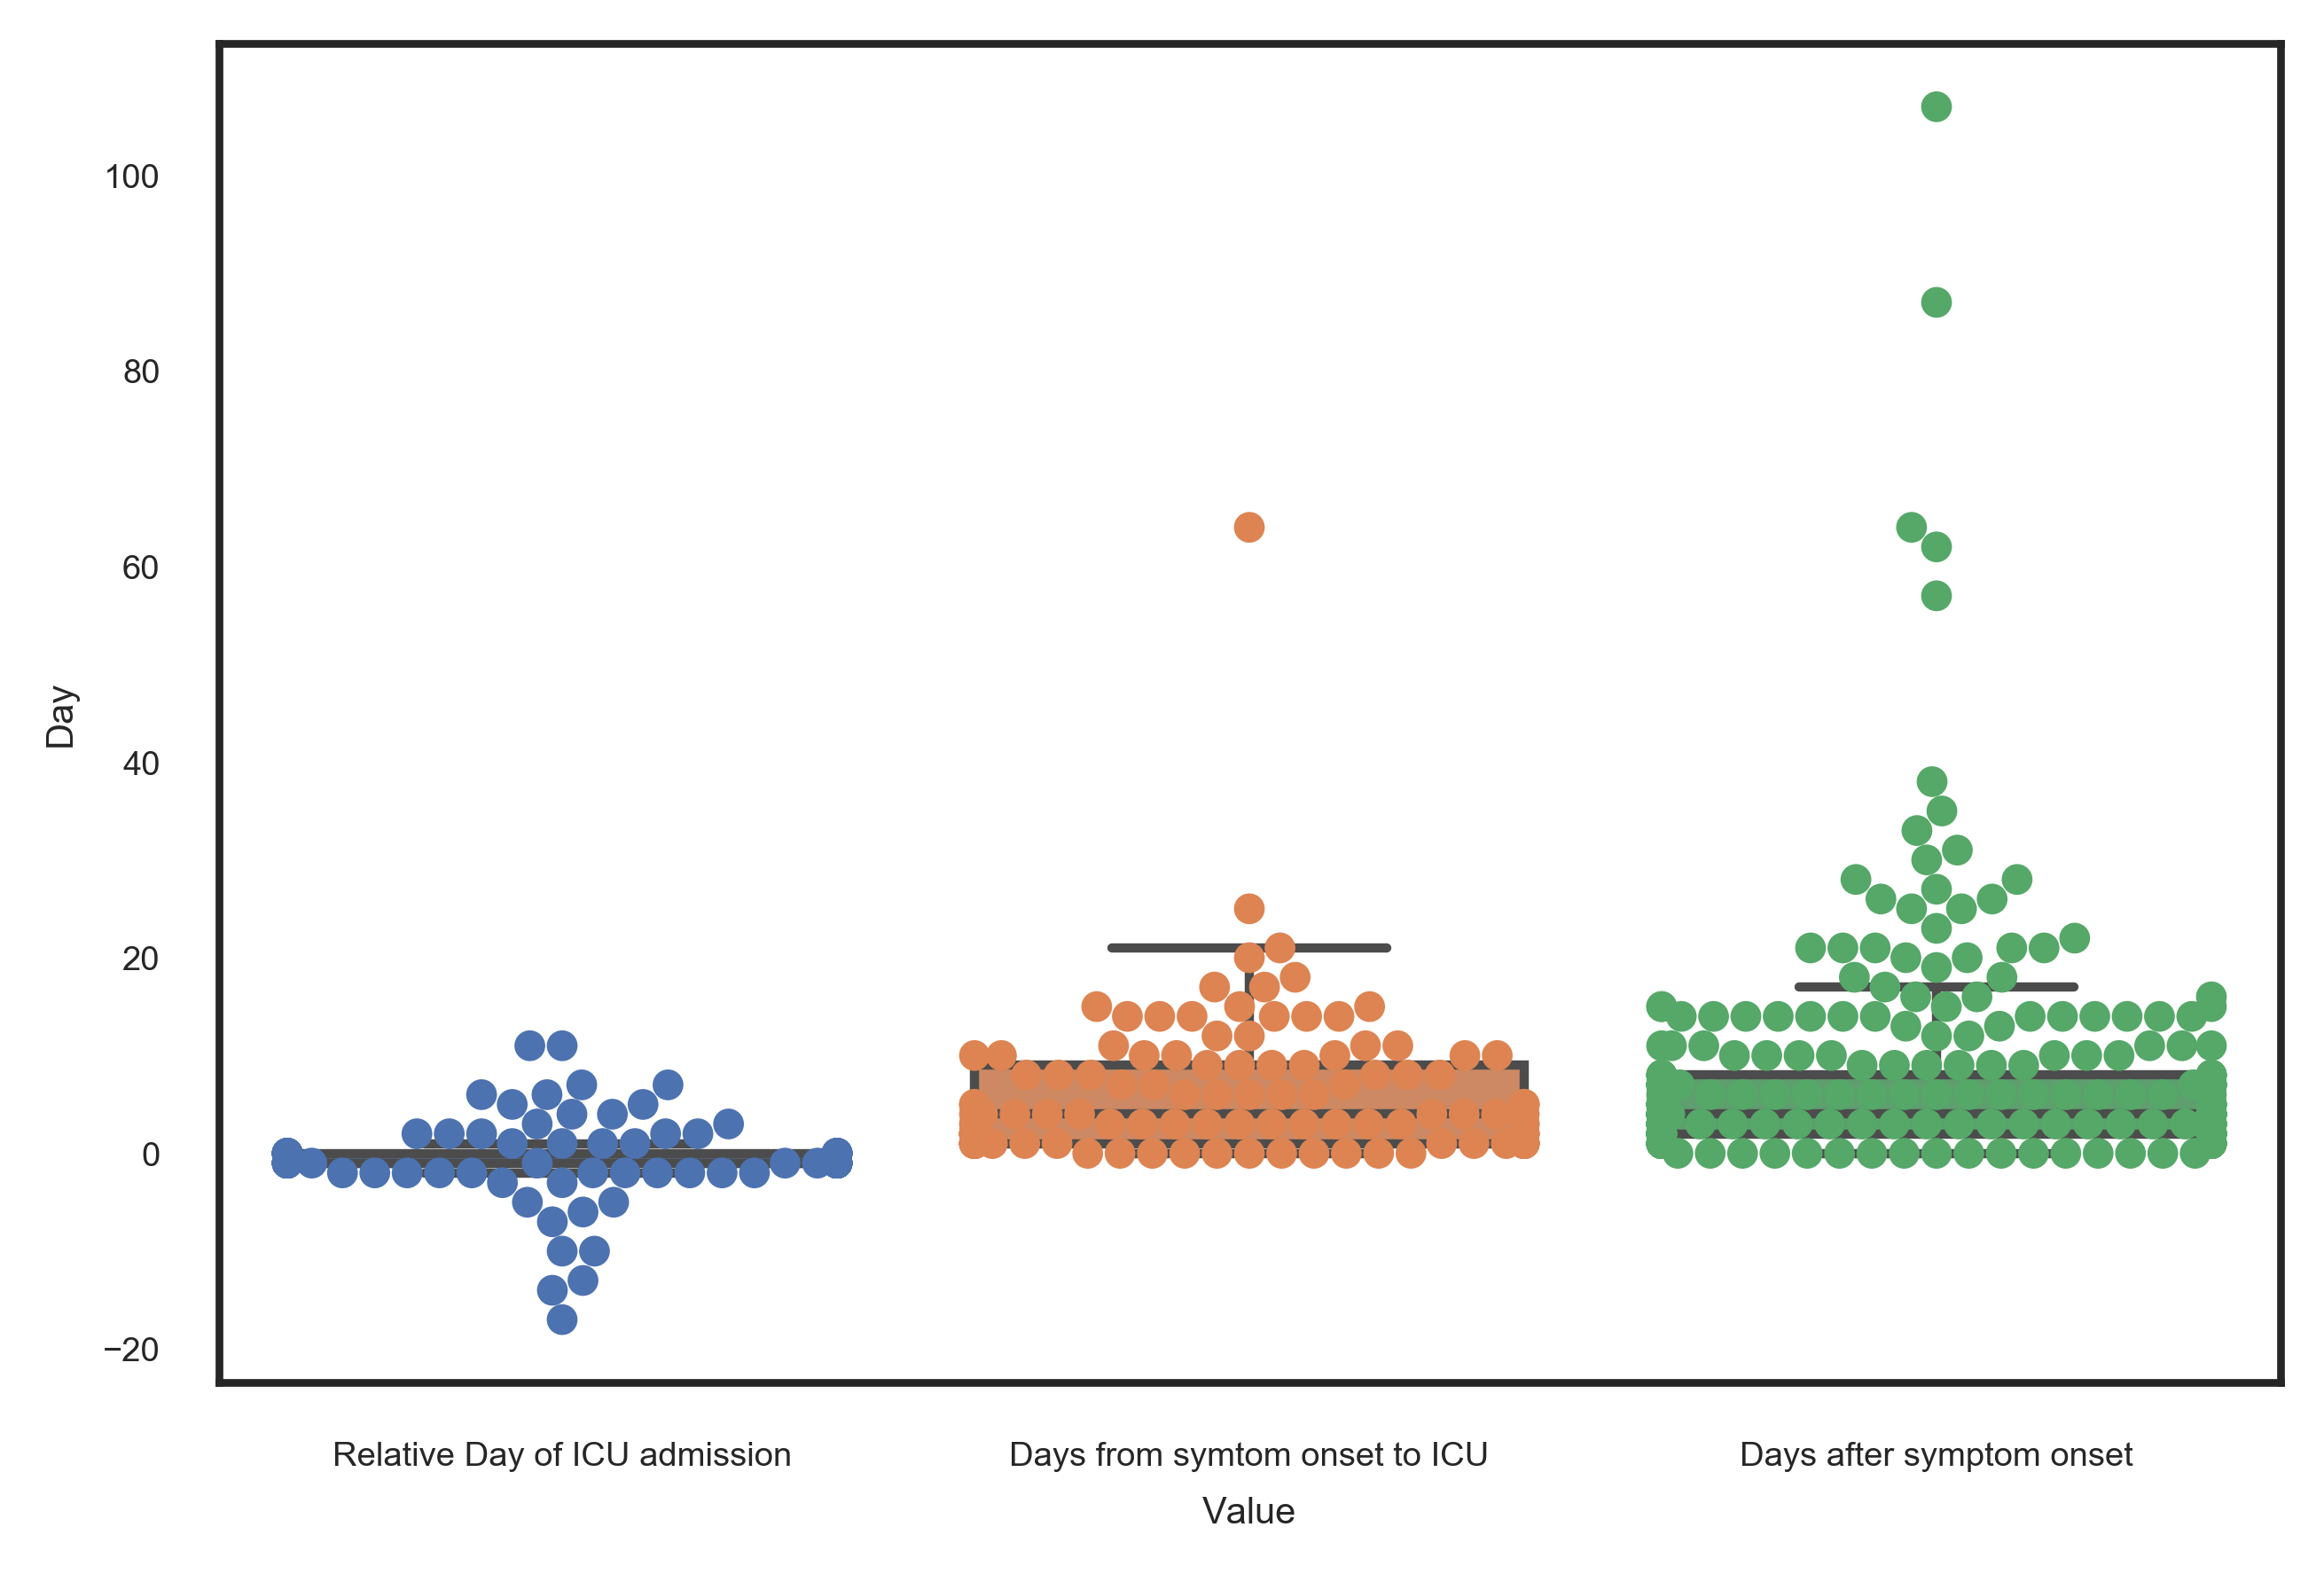

In [20]:
icu_timings = []
symptom_onset = []
bad = 0
df = {}
ind = 0
icu_from_symptom = []
for patient,icu in patient_ICU.items():
    if icu > .5:
        x = metadata_for_samples[patient_ind[patient]]
        try:
            float(x["WU350-Symptom onset"])
            float(x["Epic: Time from symptom onset to ICU (days)"])
            if not np.isnan(float(x["WU350-Symptom onset"])) and not np.isnan(float(x["Epic: Time from symptom onset to ICU (days)"])):
                icu_timings.append(float(x["Epic: Time from symptom onset to ICU (days)"]) - float(x["WU350-Symptom onset"]))
                df[ind] = {}
                df[ind]["Value"] = "Relative Day of ICU admission"
                df[ind]["Day"] = float(x["Epic: Time from symptom onset to ICU (days)"]) - float(x["WU350-Symptom onset"])
                ind += 1
                df[ind] = {}
                df[ind]["Value"] = "Days from symtom onset to ICU"
                df[ind]["Day"] = float(x["Epic: Time from symptom onset to ICU (days)"])
                icu_from_symptom.append(float(x["Epic: Time from symptom onset to ICU (days)"]))
                ind += 1
            
        except:
            #print(x["WU350-Symptom onset"],x["Epic: Time from symptom onset to ICU (days)"])
            bad += 1
            pass
    x = metadata_for_samples[patient_ind[patient]]
    try:
        v = float(x["WU350-Symptom onset"])
        if not np.isnan(v):
            df[ind] = {}
            df[ind]["Value"] = "Days after symptom onset"
            df[ind]["Day"] = v
            symptom_onset.append(v)
            ind += 1

    except:
        print(v)

    ind += 1

plt.figure()
print(np.mean(symptom_onset),np.std(symptom_onset),len(symptom_onset))
print(np.mean(icu_timings),np.std(icu_timings),len(icu_timings))
print(np.mean(icu_from_symptom),np.std(icu_from_symptom),len(icu_from_symptom))

df = pd.DataFrame.from_dict(df,orient="index")
plt.figure()
sb.set(font_scale=.5,font="Arial",style="white")
sb.boxplot(data=df,x="Value",y="Day",fliersize=0)
sb.swarmplot(data=df,x="Value",y="Day",dodge=True)
print(symptom_onset)
print(df)
#print(len(df[(df["Value"] == "Relative Day of ICU admission") & (df["Day"] <=0)]))

In [21]:
measurement_data = pd.read_csv("../data/PMN_CRP_d-dimer_CO2_Comorbidities_updated_all_data_rel_cyto_new_comorb.csv",index_col=0)
print(measurement_data.columns.values)
goodCols = list(measurement_data.columns.values)[:16] + list(measurement_data.columns.values)[-14:] + ["Any drug"]
measurement_data = measurement_data[goodCols]
measurement_data


['CRP' 'D-dimer' 'Neutrophil %' 'CO2' 'Acute respiratory failure'
 'Diabetes' 'Acute renal failure' 'Chronic kidney disease' 'Cancer' 'BMI'
 'Age' 'Smoker' 'High/Low arterial pH' 'Neutrophil absolute'
 'Lymphocyte absolute' 'Lymphocyte %' 'Hydroxychloroquine' 'Chloroquine'
 'Azithromycin' 'Remdesivir' 'Dexamethasone' 'Ravulizumab' 'Any drug'
 'IL1b' 'IL10' 'IL6' 'RANTES' 'MIP1a' 'GMCSF' 'MCP1' 'IL15' 'HGF' 'VEGF'
 'IL1Ra' 'IL2R' 'MIG' 'IL8']


,CRP,D-dimer,Neutrophil %,CO2,Acute respiratory failure,Diabetes,Acute renal failure,Chronic kidney disease,Cancer,BMI,...,GMCSF,MCP1,IL15,HGF,VEGF,IL1Ra,IL2R,MIG,IL8,Any drug
Patient,,,,,,,,,,,,,,,,,,,,,
WU350-004,80.6,-1,73.8,28,1,1,1,0,0,49.0,...,44772.447670,63593.053990,577703.7309,1.513926e+06,8.321801322,5069.217043,16182.300630,468.966261,41.105035,0
WU350-005,265.6,-1,83.5,20,1,0,1,0,0,19.6,...,1.668887,6914.503222,33.73919216,1.021053e+03,2.323624784,1817.950998,100.628636,42.837405,796.031797,0
WU350-006,273.3,7279,64.5,27,1,1,1,1,1,29.1,...,446.878740,877.786603,10.66807132,3.291130e+02,0.673823306,126.097449,60.078481,22.210721,38.481420,1
WU350-007,292.4,727,84.2,28,1,0,1,0,0,24.7,...,11.032482,1332.399745,44.61366715,1.582716e+03,1.860819849,261.067256,102.213505,66.781117,28.808149,0
WU350-008,-1.0,-1,56.8,25,0,0,0,0,0,46.5,...,78.848258,166.358442,29.87621463,5.023617e+02,0.543486802,43.854344,68.502657,26.672851,3.812572,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WU350-394,185.5,2442,81.8,20,0,1,0,1,0,35.0,...,-1.000000,-1.000000,-1,-1.000000e+00,-1,-1.000000,-1.000000,-1.000000,-1.000000,1
WU350-395,-1.0,-1,82.1,25,0,0,0,0,0,20.0,...,-1.000000,-1.000000,-1,-1.000000e+00,-1,-1.000000,-1.000000,-1.000000,-1.000000,1
WU350-397,-1.0,1014,93.3,25,0,1,1,0,0,44.6,...,-1.000000,-1.000000,-1,-1.000000e+00,-1,-1.000000,-1.000000,-1.000000,-1.000000,1


13743.479980450073

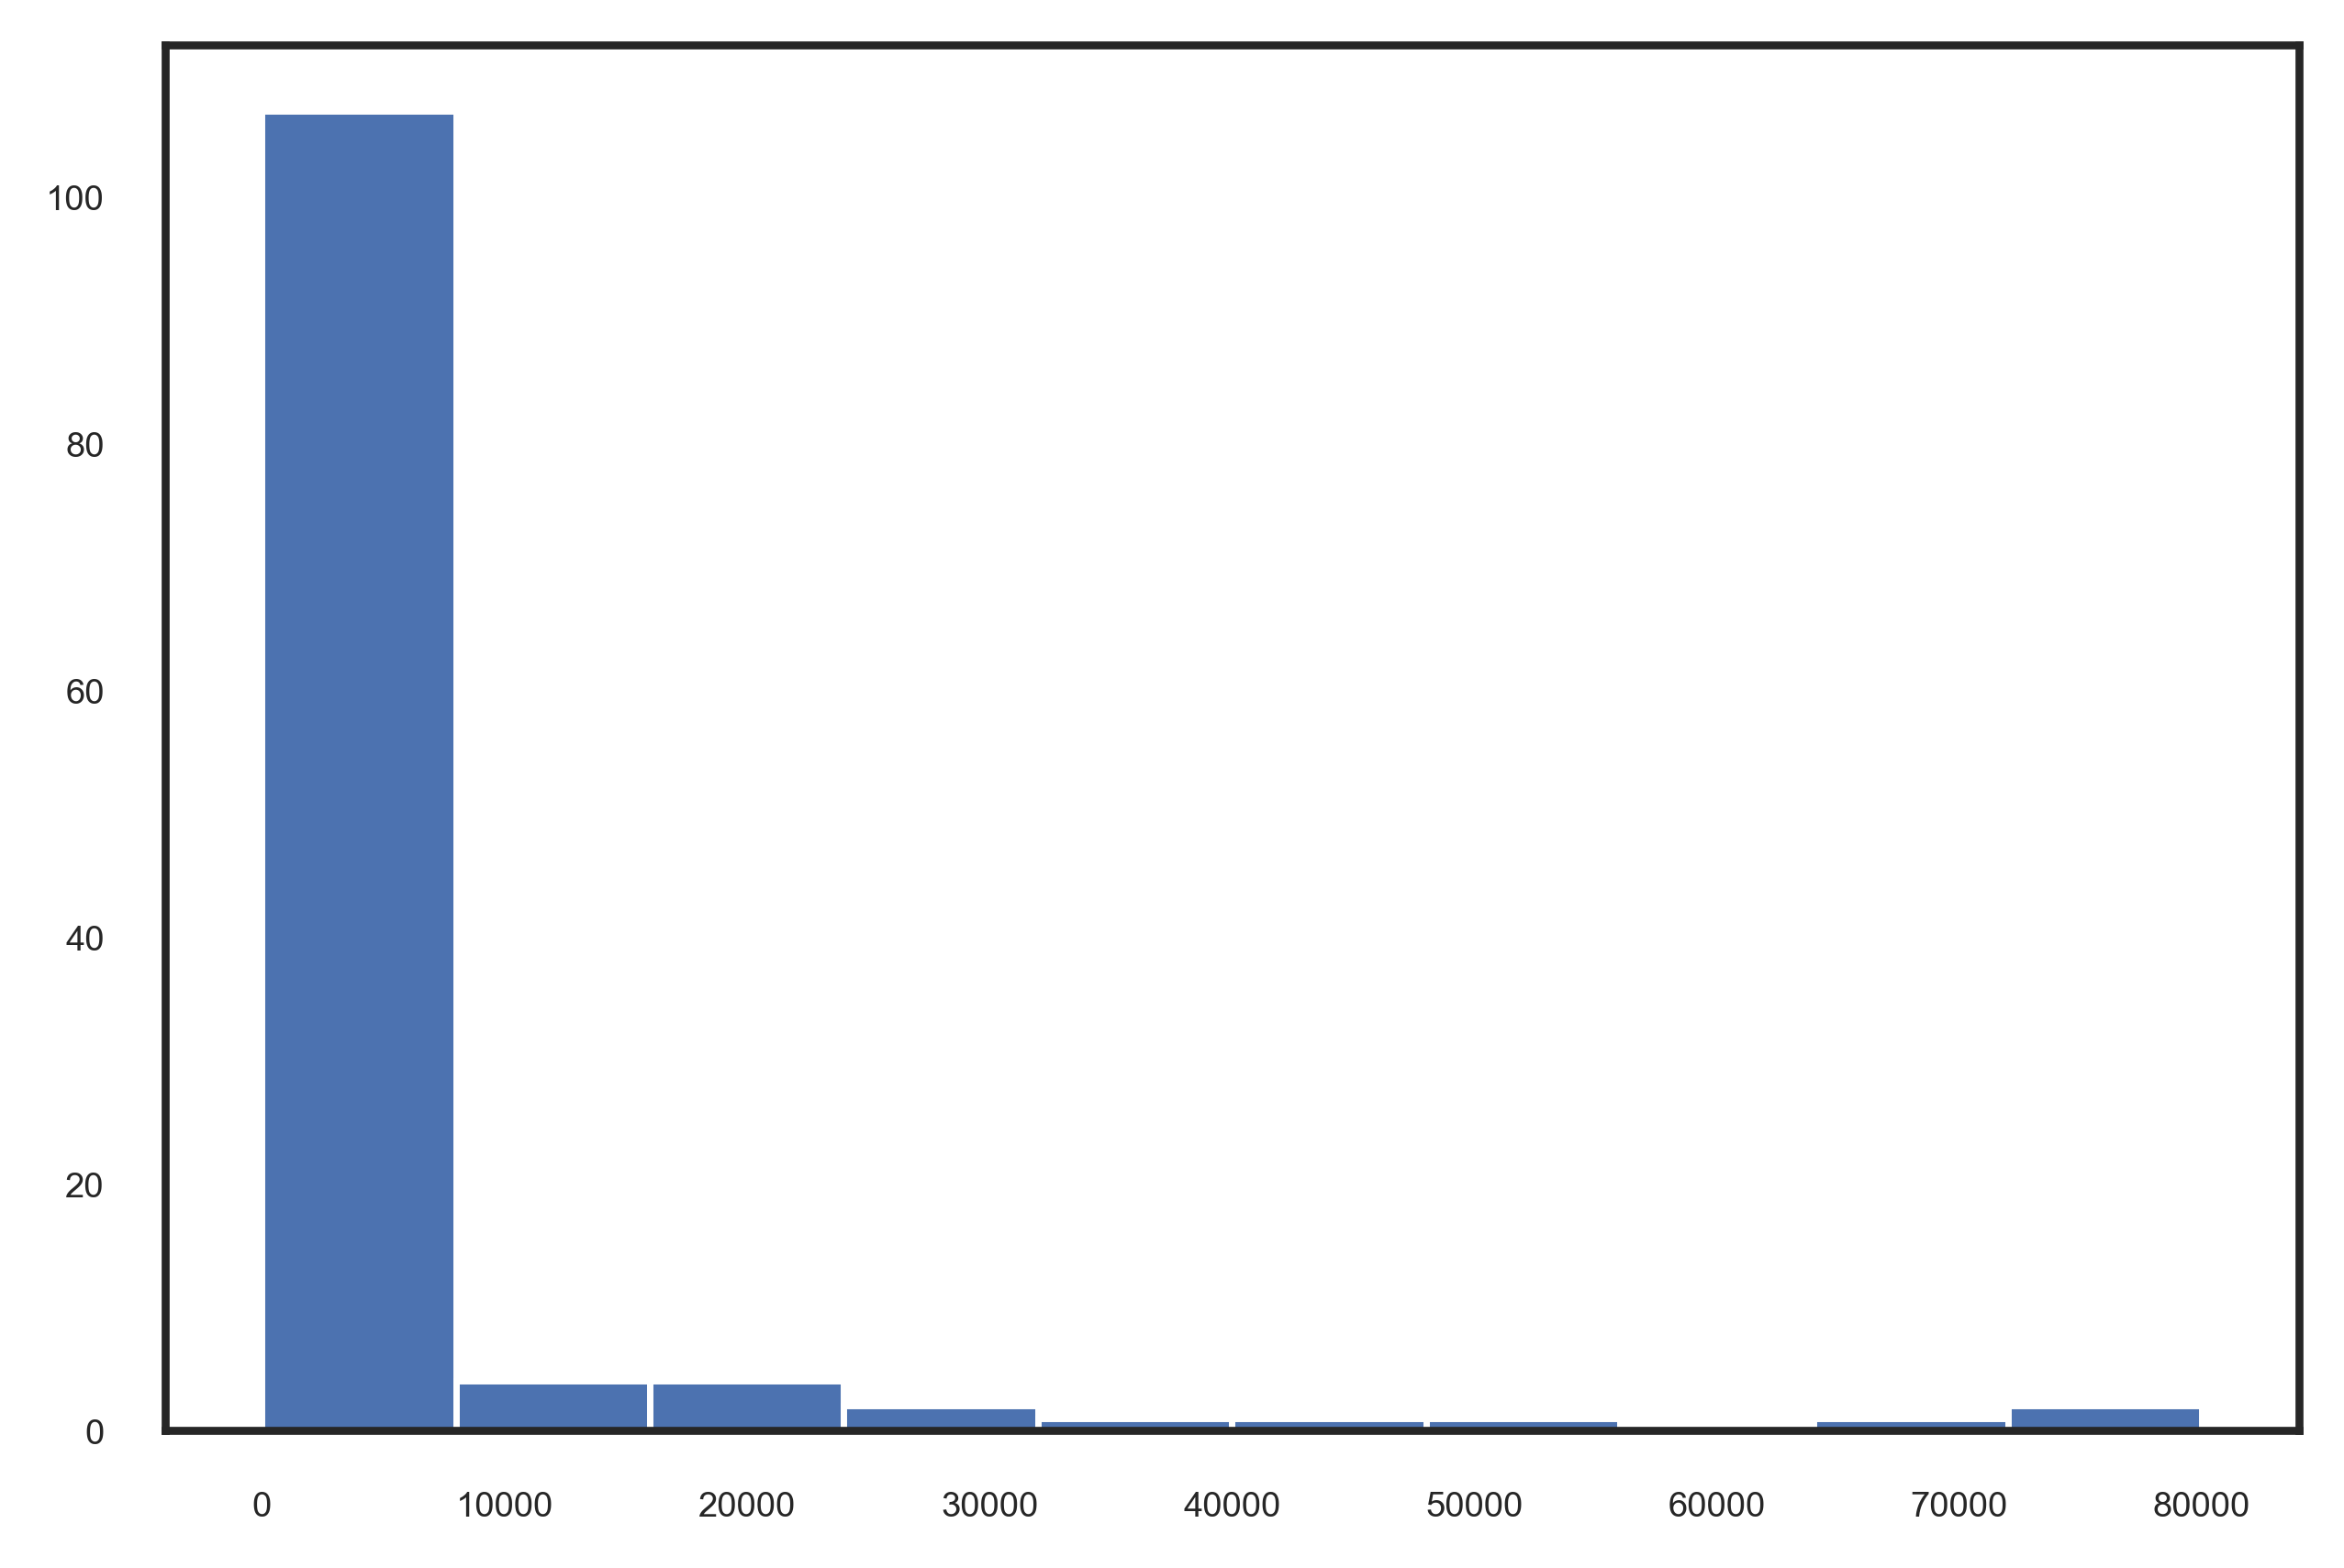

In [22]:
plt.hist([float(row["D-dimer"].replace(">","")) for index,row in measurement_data.iterrows() if row["D-dimer"] != -1 and index in patient_ICU and patient_ICU[index] > .5])
np.std([float(row["D-dimer"].replace(">","")) for index,row in measurement_data.iterrows() if row["D-dimer"] != -1 and index in patient_ICU and patient_ICU[index] > .5])

In [23]:
to_drop = []
for index,row in measurement_data.iterrows():
    if index not in patient_ids:
        to_drop.append(index)
measurement_data = measurement_data.drop(to_drop)

df = measurement_data


In [24]:
correlative_df = {mol:{fact:-1 for fact in list(measurement_data.columns.values) if fact != "Any drug"} for mol in mol_names}
pval_df = {mol:{fact:-1 for fact in list(measurement_data.columns.values) if fact != "Any drug"} for mol in mol_names}
icu2Include = [1,0]
for col in measurement_data.columns.values:
    if col != "Any drug":
        for met in range(len(mol_names)):

            plot_df = {}
            val = samp_int[:,met]
            index = 0
            for x,pat in zip(val,patient_ids):
                if pat in list(df.index.values) and patient_ICU[pat] in icu2Include:
                    comorb = df.at[pat,col]
                    if not pd.isna(comorb):
                        if type(comorb) == type(""):
                            comorb = comorb.replace("<","").replace(">","")
                        if float(comorb) > -.5:
                            if col in ["IL1b","IL10","IL6","RANTES","MIP1a","GMCSF","MCP1","IL15","HGF","VEGF","IL1Ra",
                                       "IL2R","MIG","IL8"]: comorb = np.log2(float(comorb))
                            plot_df[index] = {col:float(comorb),"Intensity":x}
                            index += 1

            plot_df = pd.DataFrame.from_dict(plot_df,orient="index")
            r,p = stats.pearsonr(plot_df[col].values,plot_df["Intensity"].values)
            print(r,col)#,plot_df[col].values,plot_df["Intensity"].values)
            correlative_df[mol_names[met]][col] = r
            pval_df[mol_names[met]][col] = p



            





-0.21790200533419427 CRP
0.4701403708928811 CRP
0.3125175795485754 CRP
-0.3909857127668796 CRP
-0.3893698793621766 CRP
-0.40839492024804247 CRP
-0.40162432510953916 CRP
-0.3514914672694496 CRP
-0.3260809313400226 CRP
-0.3831307712010479 CRP
-0.3320824254503964 CRP
-0.3489585065030628 CRP
-0.35396080724858764 CRP
-0.25963821706113066 CRP
-0.32111230855744216 CRP
-0.33269738993716036 CRP
-0.34410086382549965 CRP
-0.2982392858183205 CRP
-0.3044305628613373 CRP
-0.2584561378279921 CRP
0.4331206969730672 CRP
0.31275199226259953 CRP
-0.38466299265199705 CRP
0.28679304629083185 CRP
0.16136297024566387 CRP
-0.10913319866113551 D-dimer
-0.08504477322383723 D-dimer
-0.03362699427921749 D-dimer
-0.13331374392671272 D-dimer
-0.1345398588423458 D-dimer
-0.0926716051647382 D-dimer
-0.07913340556665201 D-dimer
-0.11306468566175938 D-dimer
-0.056298361871395544 D-dimer
-0.09898960613805145 D-dimer
-0.11660573866811712 D-dimer
-0.10161798840930845 D-dimer
-0.0844891710244532 D-dimer
-0.0673020160359487

0.199840049439906 Smoker
0.14690298190363793 Smoker
0.19881389452122586 Smoker
0.16017442896123488 Smoker
0.19956010098646898 Smoker
0.2324358295085775 Smoker
0.19427193980991697 Smoker
0.14473911269163134 Smoker
0.11088227060111756 Smoker
0.14577000547637026 Smoker
0.14486268091846535 Smoker
0.11435427687222646 Smoker
0.042665207041724905 Smoker
0.056472612764395254 Smoker
0.14085154522636084 Smoker
-0.1887990958998726 Smoker
-0.16075173865324152 Smoker
0.09862572755467224 Smoker
-0.1383147112551497 Smoker
-0.14712721620653602 Smoker
-0.19240641961263608 High/Low arterial pH
0.2380623025006303 High/Low arterial pH
0.2048897099485793 High/Low arterial pH
-0.348006770124783 High/Low arterial pH
-0.35265377244373153 High/Low arterial pH
-0.2756368189232186 High/Low arterial pH
-0.3036994676497109 High/Low arterial pH
-0.3247841301090103 High/Low arterial pH
-0.23772595786701323 High/Low arterial pH
-0.324272571573484 High/Low arterial pH
-0.3228867557385627 High/Low arterial pH
-0.292132

-0.2691705431930287 MCP1
-0.30094838233350535 MCP1
-0.2588252555329334 MCP1
-0.2709869556711251 MCP1
-0.27769726253718646 MCP1
-0.22766174687593704 MCP1
-0.20815561203476443 MCP1
-0.20993666696247065 MCP1
-0.14853688821246933 MCP1
0.2511320380201492 MCP1
0.1713450062685865 MCP1
-0.3845642575449269 MCP1
0.39044361396581007 MCP1
0.40501018594046717 MCP1
-0.022464406934687448 IL15
0.1594152281458247 IL15
0.16662516520235232 IL15
-0.020438720061281494 IL15
0.013640340349908079 IL15
-0.013455668540548839 IL15
-0.05925901880011494 IL15
0.0011567045543815816 IL15
-0.04989524795437944 IL15
-0.023253019497555164 IL15
0.03978527088651705 IL15
-0.012104310950783003 IL15
0.0038150704116317814 IL15
0.028942392415565208 IL15
0.008710742078308738 IL15
-0.03284146475707719 IL15
0.017976675721717194 IL15
0.022113795549981295 IL15
0.019151288022160144 IL15
0.06504249192697623 IL15
0.13798174051196055 IL15
0.10126760779706824 IL15
-0.21093865426141287 IL15
0.2277771921601416 IL15
0.2447455382006901 IL15


In [25]:
correlative_df = pd.DataFrame.from_dict(correlative_df,orient="index")
pval_df = pd.DataFrame.from_dict(pval_df,orient="index")
correlative_df.to_csv("../data/met_comorb_correlations_matrix_form_r.csv")


In [26]:
mask_df = deepcopy(pval_df)
ind = []
pvals = []
alpha = 0.05
for index,row in pval_df.iterrows():
    for col in pval_df.columns.values:
        ind.append((index,col))
        pvals.append(pval_df.at[index,col])
only_sig_df = {}
z = 0
reject,pvals_corr,_,_ = multipletests(pvals,alpha,method="fdr_bh")
for i,p in zip(ind,pvals_corr):
    if p < alpha:
        mask_df.at[i[0],i[1]] = 0
        if i[0] != i[1]:
            only_sig_df[z] = {"val1":i[0],"val2":i[1],"p-value (corr)":p,"correlation":correlative_df.at[i[0],i[1]]}
            z += 1
    else:
        mask_df.at[i[0],i[1]] = 1
    pval_df.at[i[0],i[1]] = p
pval_df.to_csv("../data/met_comorb_correlations_matrix_form_p.csv")
only_sig_df = pd.DataFrame.from_dict(only_sig_df,orient="index").to_csv("../data/comorb_met_correlations_list_form.csv")        

def name_conv(name):
    return name.replace(name.split("_")[0],"")

<Figure size 3000x2000 with 0 Axes>

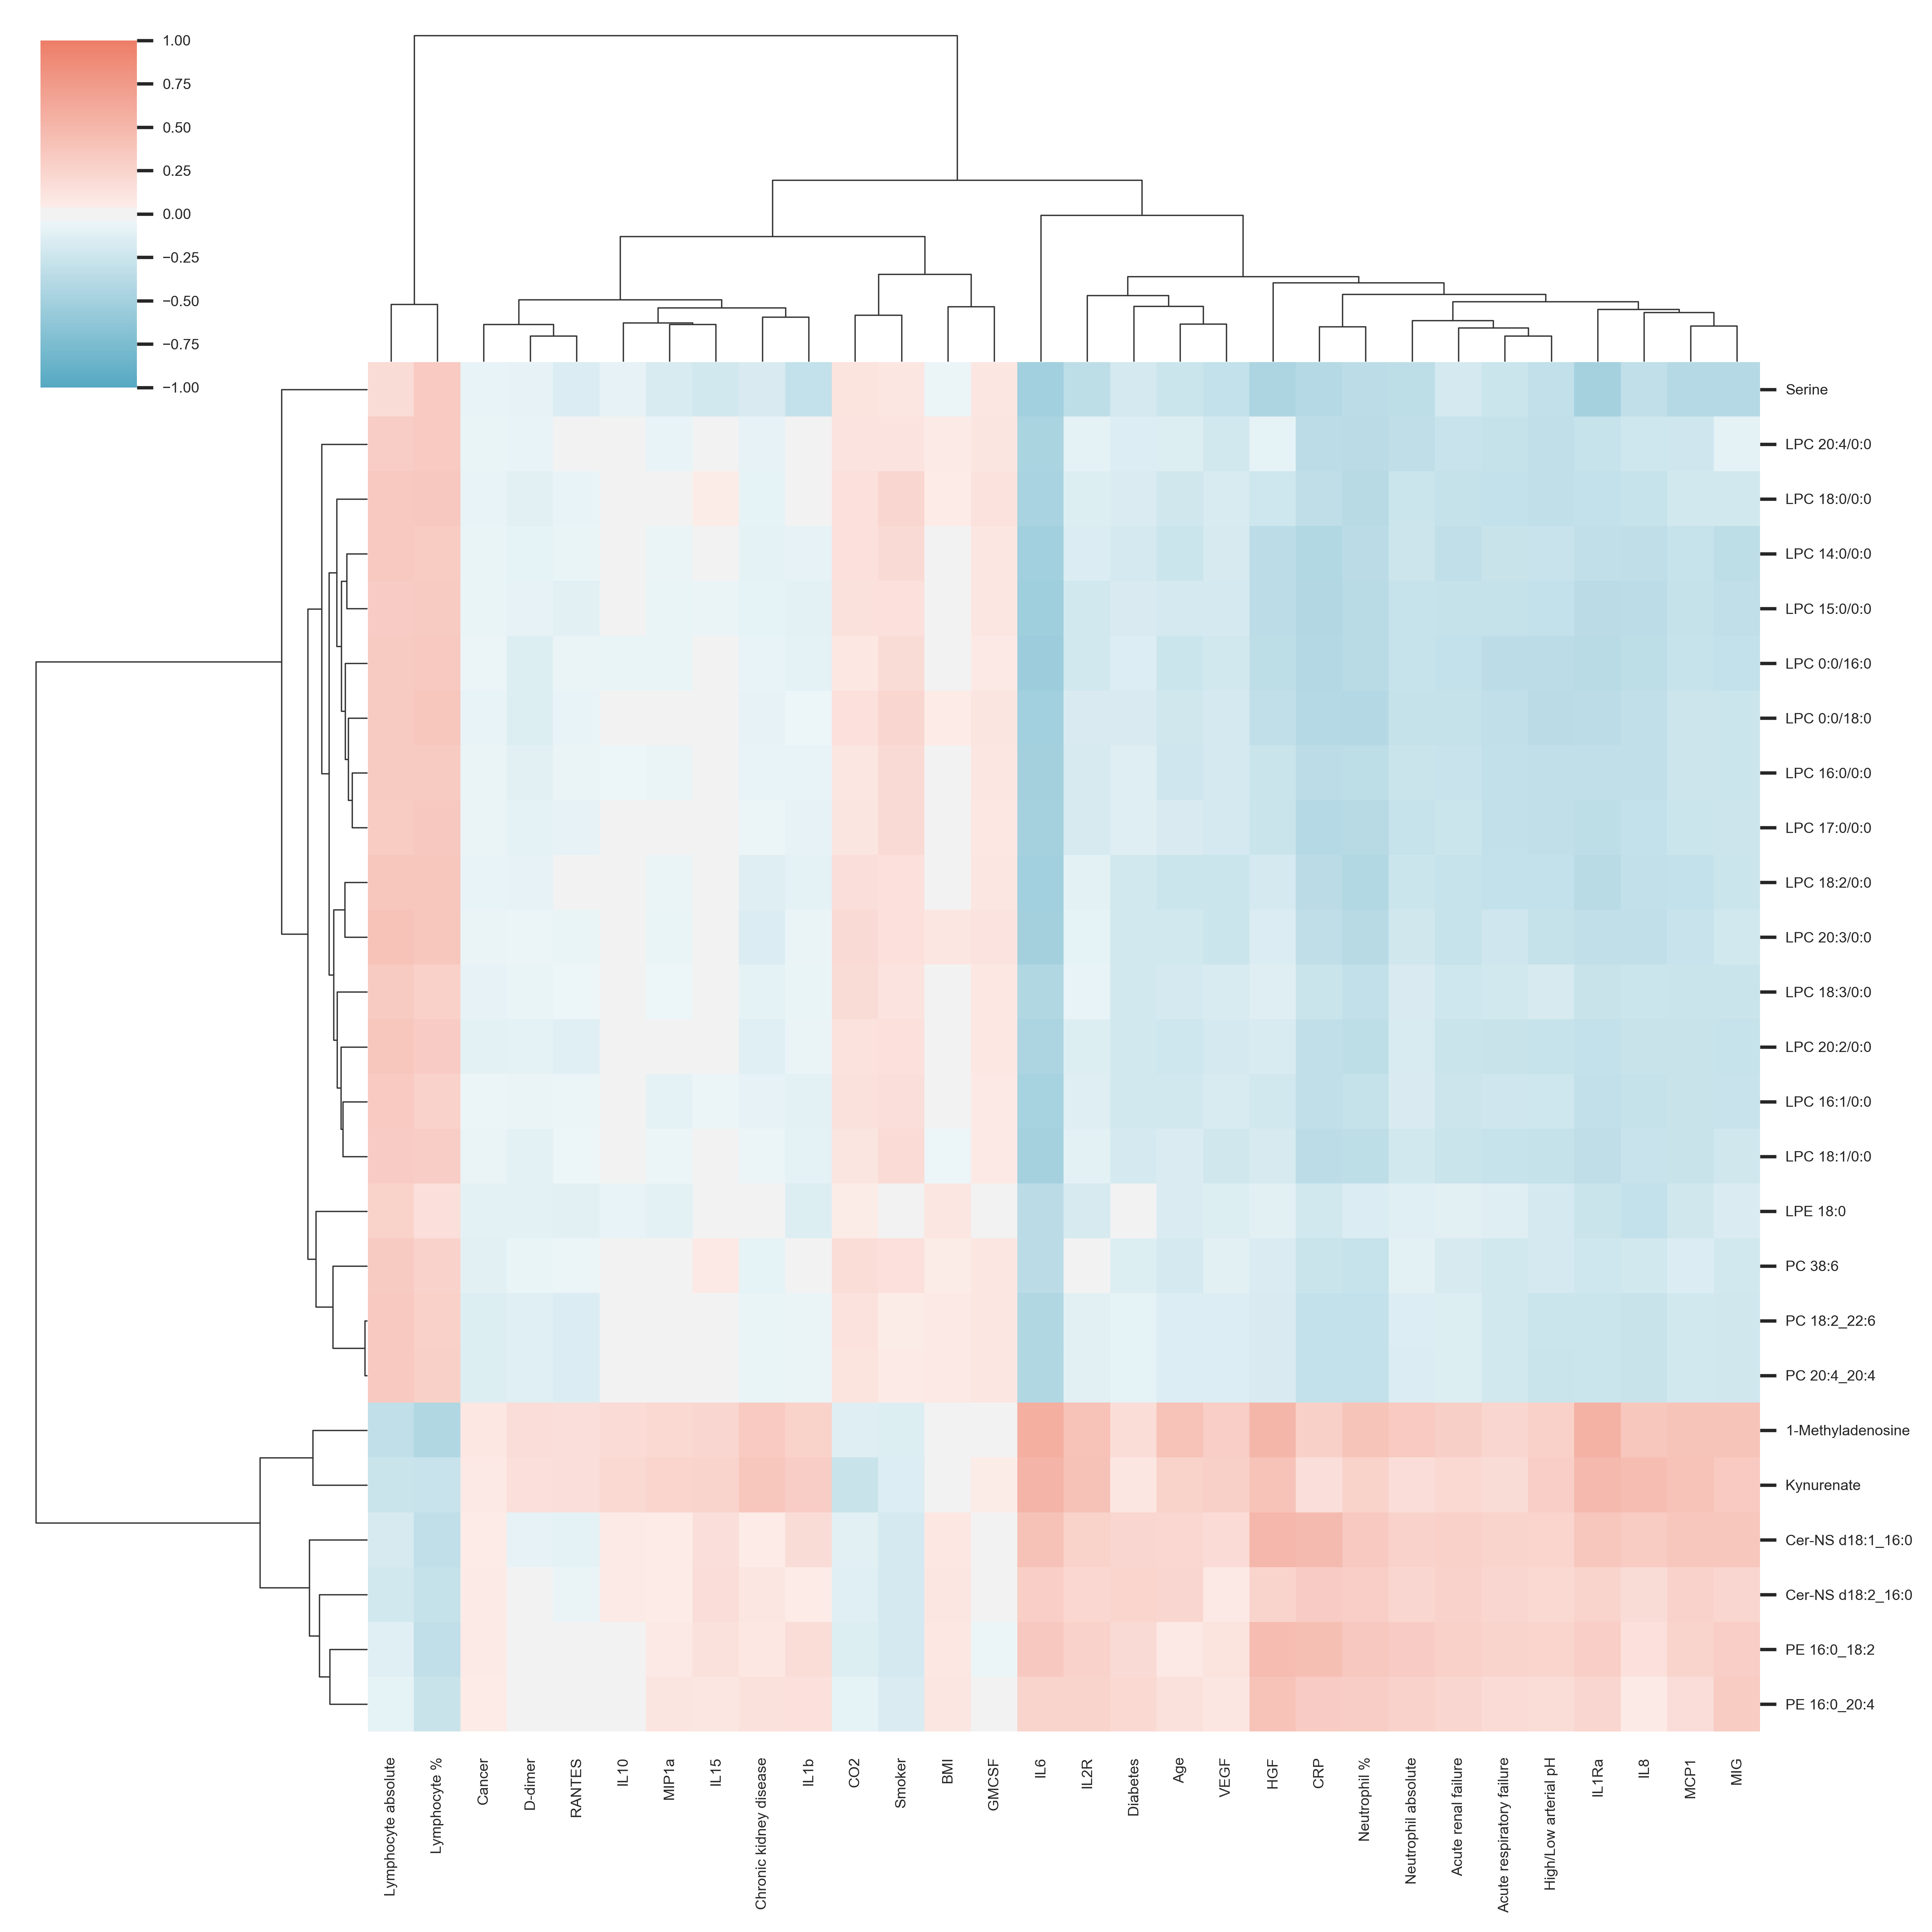

<Figure size 3000x2000 with 0 Axes>

In [27]:

sb.clustermap(correlative_df,vmax=1.0,vmin=-1,cmap=sb.diverging_palette(220, 20, l=65, center="light", as_cmap=True))

plt.figure()

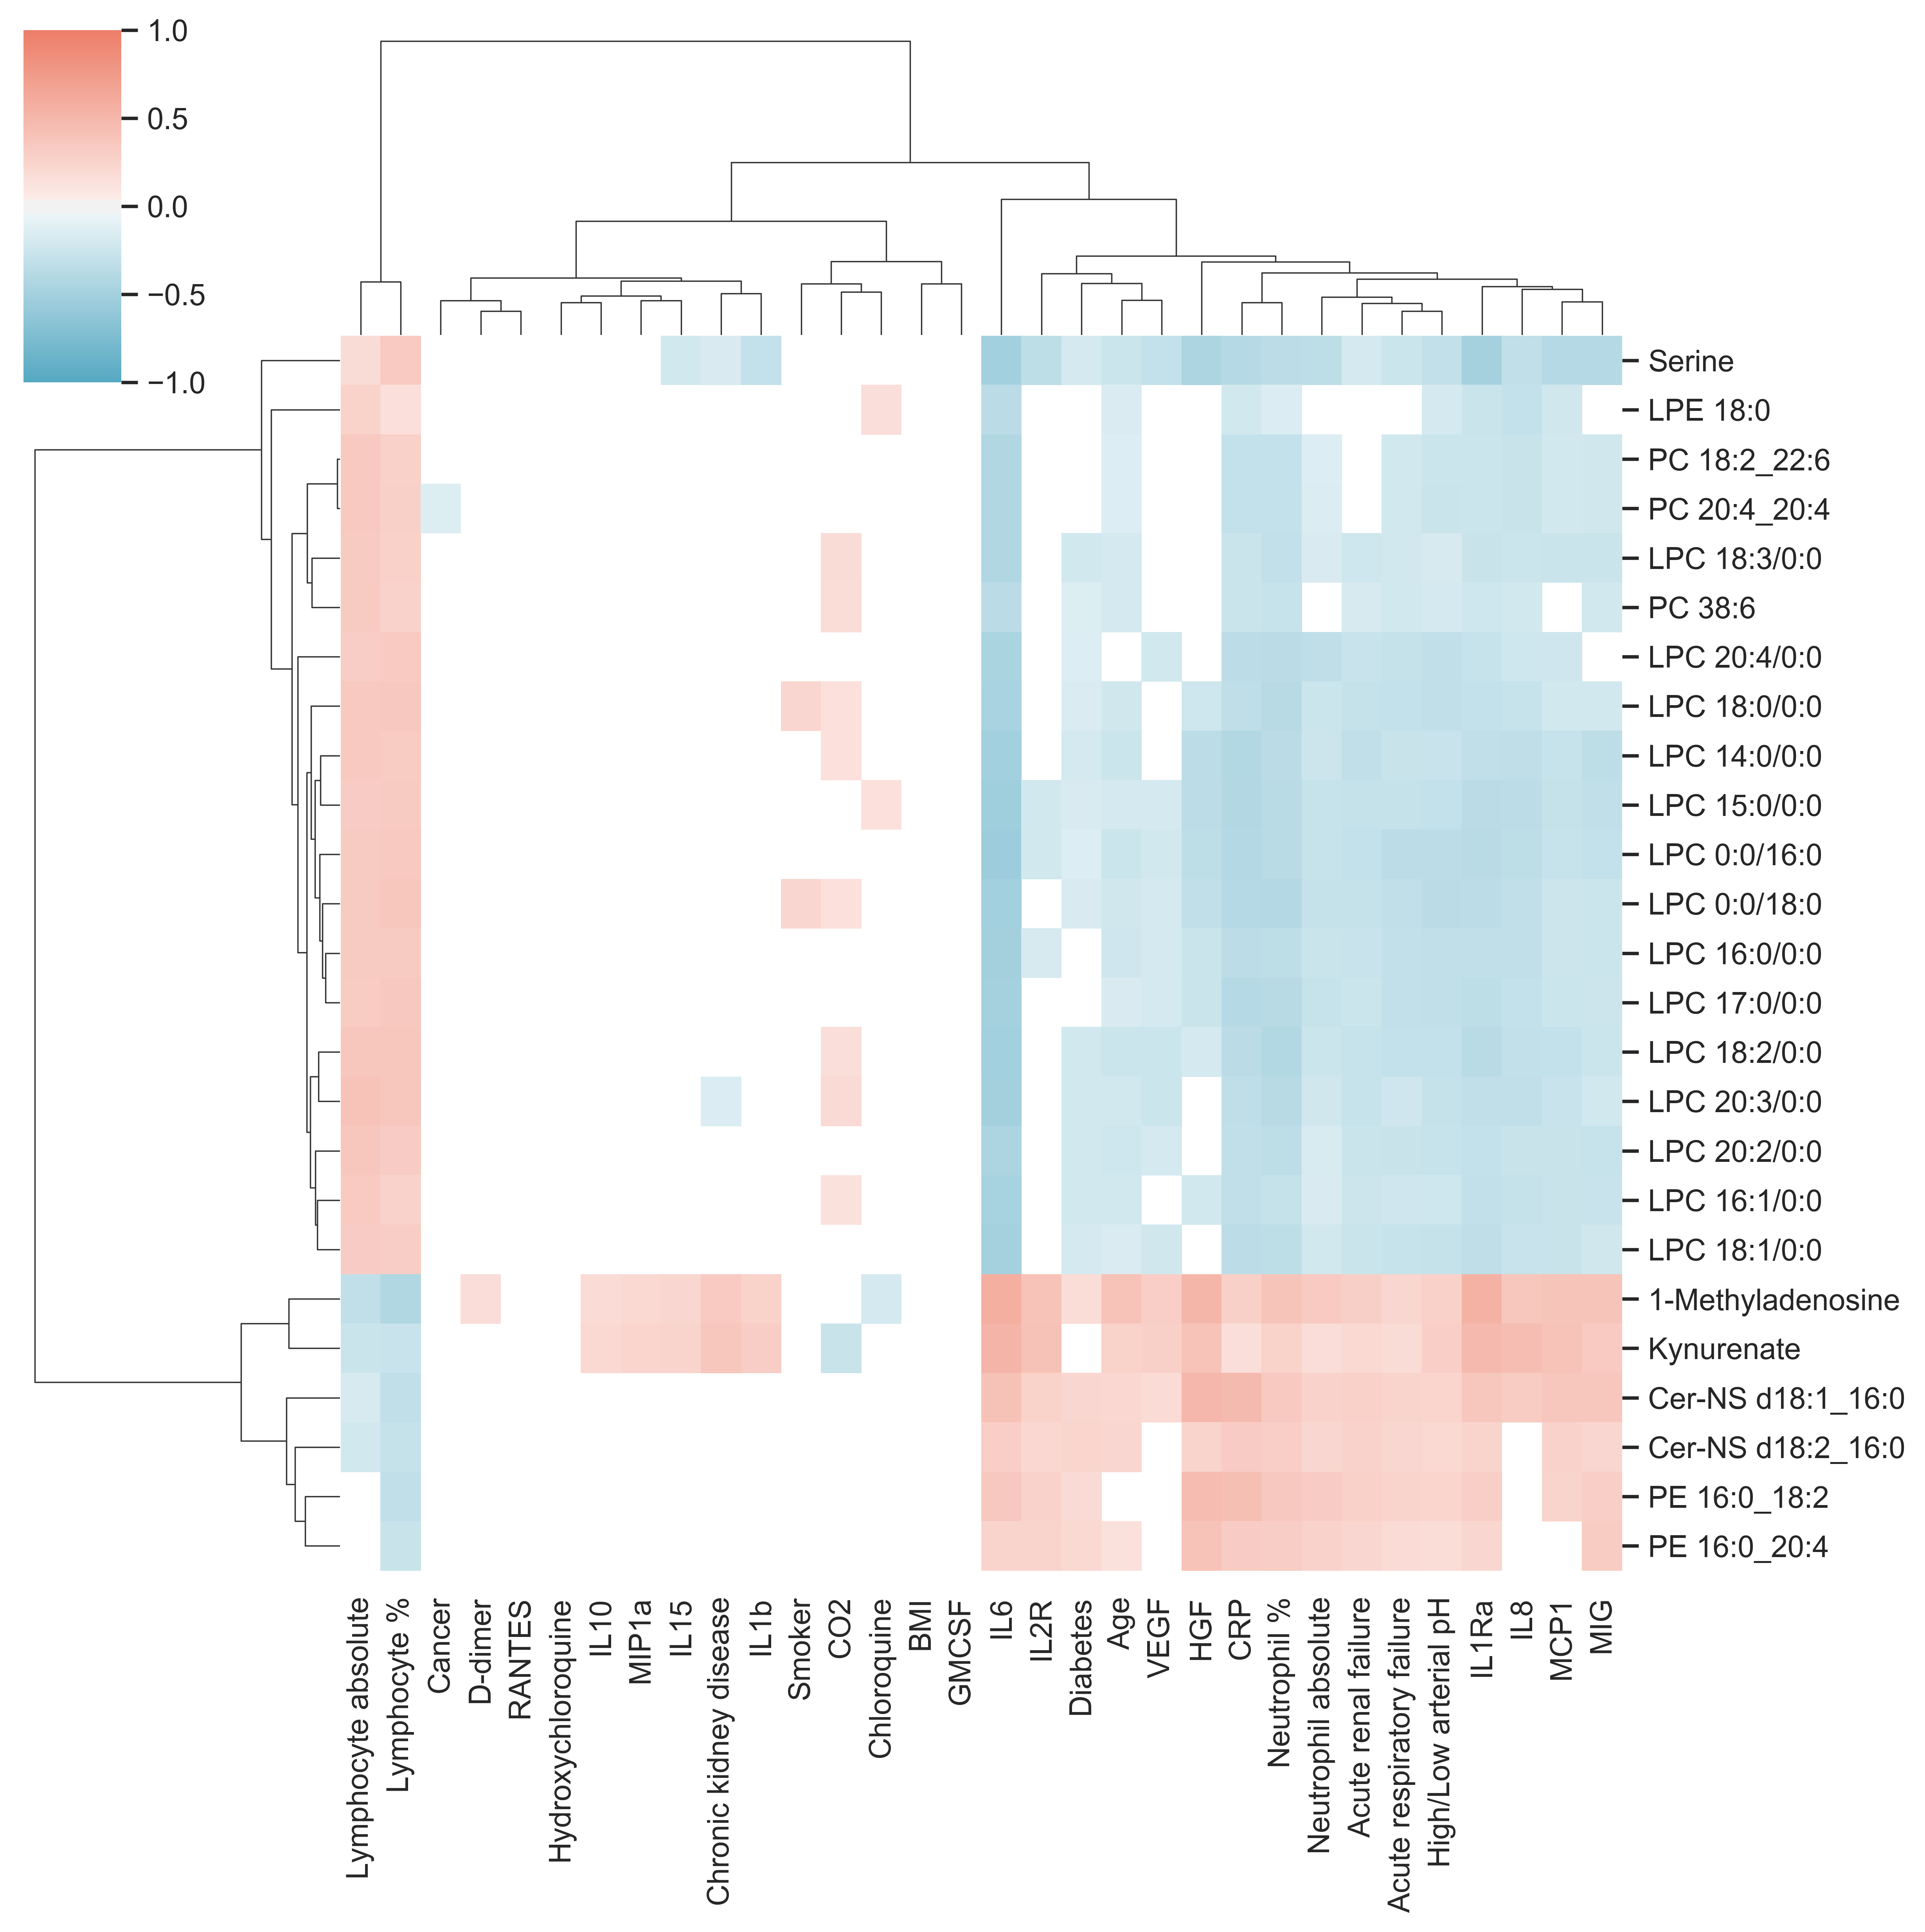

In [11]:
sb.clustermap(correlative_df,vmax=1.0,vmin=-1,cmap=sb.diverging_palette(220, 20, l=65, center="light", as_cmap=True),mask=mask_df.astype(bool))


In [12]:
cross_corr_df = {}
cross_corr_pval = {}

for col in measurement_data.columns.values:
    if col != "Any drug":
        cross_corr_df[col] = {}
        cross_corr_pval[col] = {}
        for col2 in measurement_data.columns.values:
            if col2 != "Any drug":

                goodPat1 = []
                for pat in measurement_data.index.values:
                    comorb = df.at[pat,col]
                    if not pd.isna(comorb):
                        if type(comorb) == type(""):
                            comorb = comorb.replace("<","").replace(">","")
                        if float(comorb) > -.5:
                            goodPat1.append(pat)

                goodPat2 = []
                for pat in measurement_data.index.values:
                    comorb = df.at[pat,col2]
                    if not pd.isna(comorb):
                        if type(comorb) == type(""):
                            comorb = comorb.replace("<","").replace(">","")
                        if float(comorb) > -.5:
                            goodPat2.append(pat)

                goodPat = set(goodPat1).intersection(goodPat2)

                val1 = []
                val2 = []
                for pat in goodPat:
                    v1 = measurement_data.at[pat,col]
                    v2 = measurement_data.at[pat,col2]
                    if type(v1) == type(""):
                        v1 = v1.replace("<","").replace(">","")
                    if type(v2) == type(""):
                        v2 = v2.replace("<","").replace(">","")
                    if float(v1) > -.5 and float(v2) > -.5:
                        if col in ["IL1b","IL10","IL6","RANTES","MIP1a","GMCSF","MCP1","IL15","HGF","VEGF","IL1Ra",
                                       "IL2R","MIG","IL8"]: v1 = np.log2(float(v1))
                        if col2 in ["IL1b","IL10","IL6","RANTES","MIP1a","GMCSF","MCP1","IL15","HGF","VEGF","IL1Ra",
                                       "IL2R","MIG","IL8"]: v2 = np.log2(float(v2))
                        val1.append(float(v1))
                        val2.append(float(v2))

                r,p = stats.pearsonr(val1,val2)
                print(col,col2,r,p)
                cross_corr_df[col][col2] = r
                cross_corr_pval[col][col2] = p

cross_corr_df = pd.DataFrame.from_dict(cross_corr_df,orient="index")
cross_corr_pval = pd.DataFrame.from_dict(cross_corr_pval,orient="index")
cross_corr_df.to_csv("../data/comorb_comorb_correlations_matrix_form_r.csv")

            





CRP CRP 1.0 0.0
CRP D-dimer 0.15947743230850928 0.031051780528100027
CRP Neutrophil % 0.48700063498030083 4.556229869466461e-13
CRP CO2 0.06266647687415124 0.37681574162189435
CRP Acute respiratory failure 0.4089896964471681 1.660065846025752e-09
CRP Diabetes 0.057682029401279915 0.41601107710360236
CRP Acute renal failure 0.19304857844209783 0.006037407547812615
CRP Chronic kidney disease 0.07343369415295857 0.3001981186794977
CRP Cancer 0.03580667602538683 0.6138095739476946
CRP BMI -0.05294008377508066 0.45656476606972846
CRP Age 0.14034960649441502 0.046896223553086064
CRP Smoker -0.20357398597103418 0.060110802922122245
CRP High/Low arterial pH 0.4498416521121984 2.0926343898598777e-11
CRP Neutrophil absolute 0.5557826704602687 2.776892340357946e-17
CRP Lymphocyte absolute -0.2144927444959993 0.002472415463501498
CRP Lymphocyte % -0.4674870158240897 4.3373561986629104e-12
CRP Hydroxychloroquine 0.16319320009520724 0.02062536728958802
CRP Chloroquine -0.10800833241077493 0.12695998

Diabetes CO2 -0.06472145138944767 0.25745534136164866
Diabetes Acute respiratory failure 0.1486513968706817 0.00754138725894297
Diabetes Diabetes 1.0 0.0
Diabetes Acute renal failure 0.22119440175166347 6.242392816984065e-05
Diabetes Chronic kidney disease 0.26141791009261683 1.9777268115195333e-06
Diabetes Cancer 0.008320134369077616 0.8817734498441633
Diabetes BMI 0.14369127306330423 0.010299179966744895
Diabetes Age 0.29345859574631467 8.139664234061634e-08
Diabetes Smoker -0.23799954945302967 0.003468915982723852
Diabetes High/Low arterial pH 0.06732645053613222 0.2282808777724751
Diabetes Neutrophil absolute 0.008647017166942971 0.8808447786087353
Diabetes Lymphocyte absolute -0.04948572279546268 0.3891223233108645
Diabetes Lymphocyte % -0.0494800797818717 0.3891764706273599
Diabetes Hydroxychloroquine 0.06683713363177624 0.23168754651536747
Diabetes Chloroquine 0.03395405331543578 0.5437916415447643
Diabetes IL1b 0.02639030228616599 0.7552293885541032
Diabetes IL10 0.055386118530

BMI Chloroquine 0.045667638581481276 0.4170285259101516
BMI IL1b -0.05498074079475916 0.5157748327216899
BMI IL10 0.06260898515813683 0.4591759284336548
BMI IL6 -0.09988696398236792 0.23691599475842293
BMI RANTES -0.18020157107610066 0.03187541608931033
BMI MIP1a -0.1090664130050242 0.19634089327398938
BMI GMCSF 0.11738199661905142 0.16415899238417514
BMI MCP1 -0.020515858113764225 0.8085172337351071
BMI IL15 -0.030096988250304966 0.7221718914968542
BMI HGF -0.09535520538008078 0.25897401490939026
BMI VEGF -0.052127978350529354 0.537825045821703
BMI IL1Ra -0.03734537216130523 0.6590377738071653
BMI IL2R -0.0854223929658437 0.31212313440435907
BMI MIG -0.06831072247721952 0.42089750790698277
BMI IL8 -0.0753988428782503 0.37249487109333107
Age CRP 0.14034960649441502 0.046896223553086064
Age D-dimer 0.22863007042570016 0.0008447248745310769
Age Neutrophil % 0.2012793306814431 0.0004229817349240979
Age CO2 -0.05319772971909921 0.35212298713111806
Age Acute respiratory failure 0.3206898552

Neutrophil absolute VEGF 0.3488971697831866 3.365479512832265e-05
Neutrophil absolute IL1Ra 0.4720911136952479 7.454523405740198e-09
Neutrophil absolute IL2R 0.23974615271045951 0.005099798309257916
Neutrophil absolute MIG 0.13333938596679085 0.1245576871264108
Neutrophil absolute IL8 0.070076110091158 0.41930186881510495
Lymphocyte absolute CRP -0.2144927444959993 0.002472415463501498
Lymphocyte absolute D-dimer -0.07781306354900086 0.26743736544660046
Lymphocyte absolute Neutrophil % -0.6280841326871021 1.1786874963917658e-34
Lymphocyte absolute CO2 0.035827101695829144 0.5364754606048641
Lymphocyte absolute Acute respiratory failure -0.20920649318266127 0.0002337564122708048
Lymphocyte absolute Diabetes -0.04948572279546268 0.3891223233108645
Lymphocyte absolute Acute renal failure -0.2215973501800481 9.509784447608455e-05
Lymphocyte absolute Chronic kidney disease -0.17535159998902677 0.002114510337429069
Lymphocyte absolute Cancer -0.0924264070632501 0.10718409087493856
Lymphocyte

IL1b IL1b 0.9999999999999998 0.0
IL1b IL10 0.5181162281166082 4.008782667497341e-11
IL1b IL6 0.5062280811111937 1.301621530859536e-10
IL1b RANTES 0.16021072496577915 0.056834897401537694
IL1b MIP1a 0.581544437552841 3.227567104942399e-14
IL1b GMCSF 0.45208257822239445 1.6260715739272566e-08
IL1b MCP1 0.6810563767301355 1.1020072147367408e-20
IL1b IL15 0.6164771408029771 3.151996156219195e-16
IL1b HGF 0.45093429032889426 1.7855477928633484e-08
IL1b VEGF 0.4629267094698489 6.606027657620595e-09
IL1b IL1Ra 0.657098503729923 6.649246215716419e-19
IL1b IL2R 0.6699270868293095 7.760884314144219e-20
IL1b MIG 0.4671933910772256 5.214343789622902e-09
IL1b IL8 0.3032611032842778 0.0002438700056910229
IL10 CRP 0.26838970023550823 0.0042204568378588665
IL10 D-dimer 0.2960662648236206 0.0012515581775861013
IL10 Neutrophil % 0.09757822227188268 0.2602066085505123
IL10 CO2 0.08325120252621995 0.3281193392115459
IL10 Acute respiratory failure 0.06558855619087287 0.43804114913938386
IL10 Diabetes 0.055

GMCSF MCP1 0.2480924527217029 0.0029116195426165414
GMCSF IL15 0.4437956478919072 3.169812922306369e-08
GMCSF HGF 0.11439523272565702 0.17523208505175203
GMCSF VEGF 0.23275141483717182 0.0053128453773630836
GMCSF IL1Ra 0.18989543435097464 0.0236048103454519
GMCSF IL2R 0.3261556655716139 7.459972361847888e-05
GMCSF MIG 0.08402307448603791 0.32188562809778837
GMCSF IL8 -0.0632627921472025 0.4544905188784914
MCP1 CRP 0.43997324528869347 1.2103569672399381e-06
MCP1 D-dimer 0.4373748634928055 9.142221508534953e-07
MCP1 Neutrophil % 0.34380202383220254 4.452746553994664e-05
MCP1 CO2 0.023813709142367388 0.7800291556426794
MCP1 Acute respiratory failure 0.20635986282706742 0.01374318089699885
MCP1 Diabetes 0.11086321955607313 0.18902670634069277
MCP1 Acute renal failure 0.20092108674466408 0.016503233426872634
MCP1 Chronic kidney disease 0.09379785441127081 0.2668693422836865
MCP1 Cancer 0.17129759957035884 0.041520354932442445
MCP1 BMI -0.020515858113764225 0.8085172337351071
MCP1 Age 0.2944

IL2R Cancer 0.2610730956125797 0.0017001376041295905
IL2R BMI -0.0854223929658437 0.31212313440435907
IL2R Age 0.2908977559665005 0.0004446236265367603
IL2R Smoker -0.12408270949742159 0.32472799073753206
IL2R High/Low arterial pH 0.2811127262987242 0.000701890883381672
IL2R Neutrophil absolute 0.23974615271045951 0.005099798309257916
IL2R Lymphocyte absolute -0.12418446864211269 0.14822582509061374
IL2R Lymphocyte % -0.20019491277512505 0.018999136773365073
IL2R Hydroxychloroquine 0.1525111012097787 0.06999683847330254
IL2R Chloroquine -0.19231742233636584 0.021852712148982413
IL2R IL1b 0.6699270868293095 7.760884314144219e-20
IL2R IL10 0.44151872581051044 3.796133948093132e-08
IL2R IL6 0.4404537653135148 4.1282995726205545e-08
IL2R RANTES 0.16393381700383003 0.05124290539803756
IL2R MIP1a 0.4718069867827964 3.0851866282233623e-09
IL2R GMCSF 0.3261556655716139 7.459972361847888e-05
IL2R MCP1 0.5847664798964388 2.1550364918742954e-14
IL2R IL15 0.5402094093944463 3.964560682340818e-12
I

ValueError: The condensed distance matrix must contain only finite values.

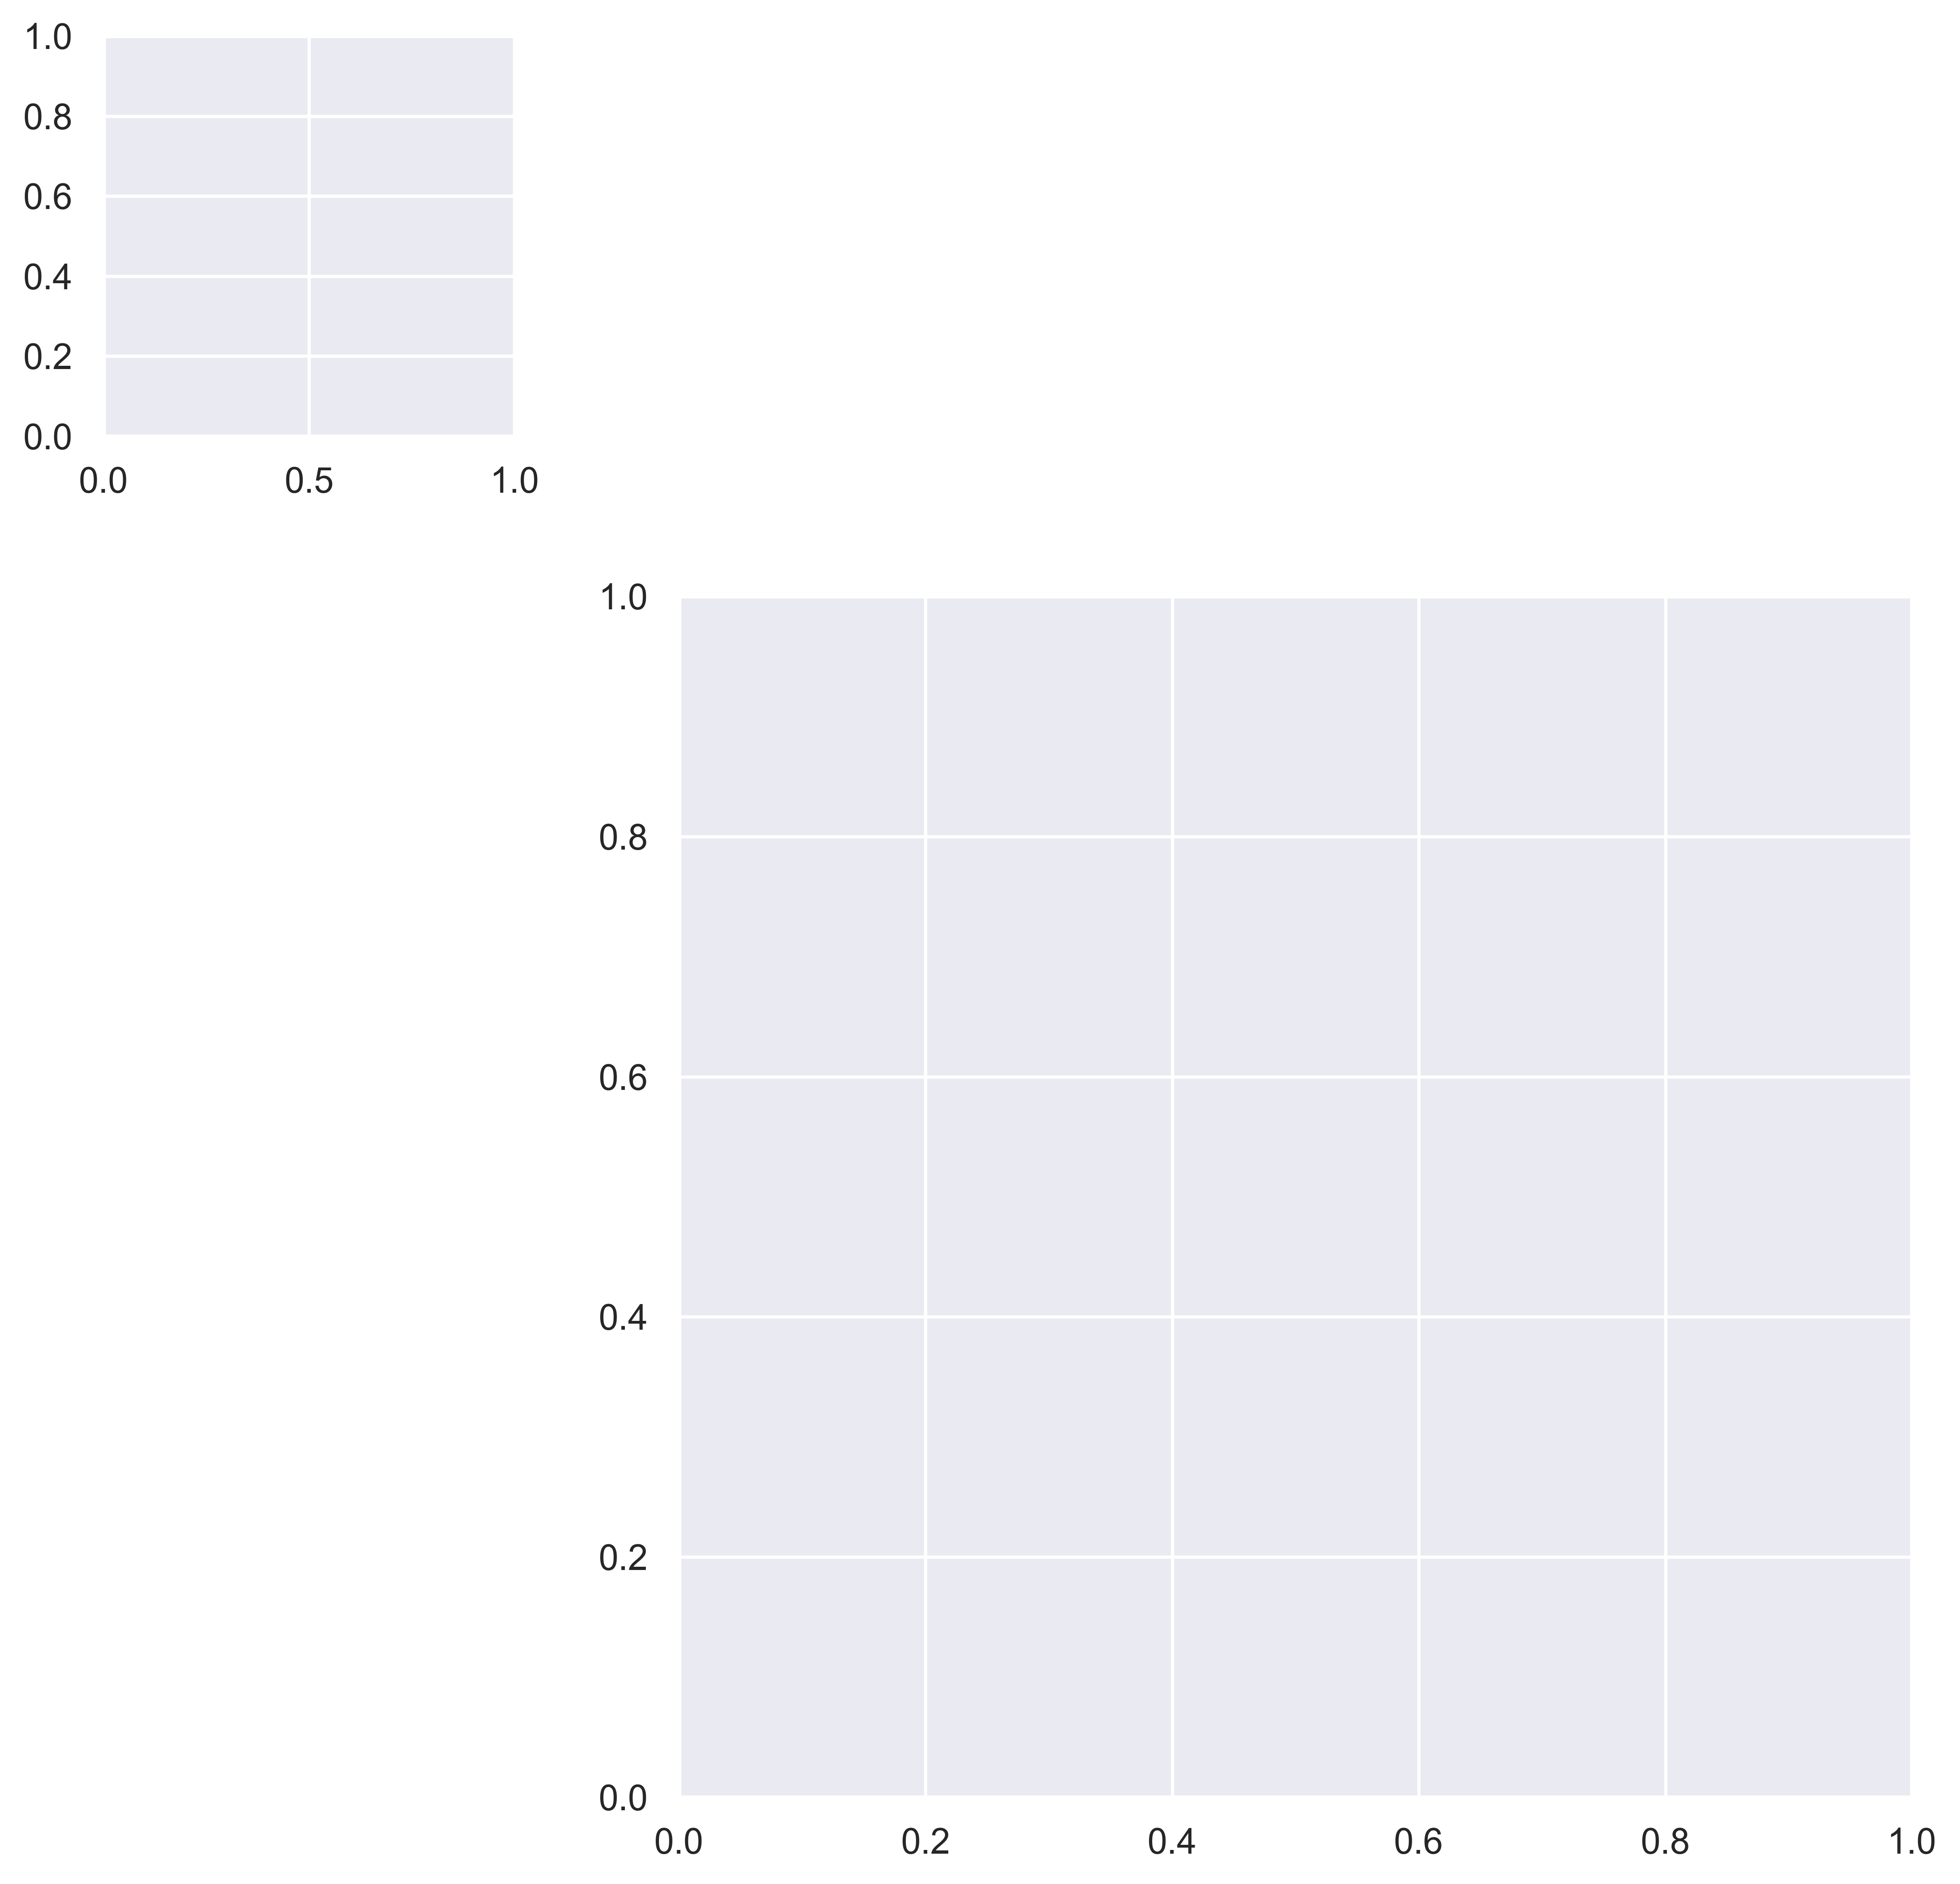

In [13]:
sb.set(font_scale=1.0)
sb.clustermap(cross_corr_df,vmax = 1.0,vmin=-1.0,cmap=sb.diverging_palette(220, 20, l=65, center="light", as_cmap=True),dendrogram_ratio=.25)

In [ ]:
mask_df = deepcopy(cross_corr_pval)
ind = []
pvals = []
alpha = 0.05
for index,row in cross_corr_pval.iterrows():
    for col in cross_corr_pval.columns.values:
        ind.append((index,col))
        pvals.append(cross_corr_pval.at[index,col])

only_sig_df = {}
z = 0
reject,pvals_corr,_,_ = multipletests(pvals,alpha,method="fdr_bh")
found = []
for i,p in zip(ind,pvals_corr):
    if p < alpha:
        mask_df.at[i[0],i[1]] = 0
        tmp = list(i)
        tmp.sort()
        if i[0] != i[1]:
            if tmp not in found:
                found.append(tmp)
                only_sig_df[z] = {"val1":i[0],"val2":i[1],"p-value (corr)":p,"correlation":cross_corr_df.at[i[0],i[1]]}
                z += 1
    else:
        mask_df.at[i[0],i[1]] = 1
    cross_corr_pval.at[i[0],i[1]] = p
    
cross_corr_pval.to_csv("../data/comorb_comorb_correlations_matrix_form_p.csv")
only_sig_df = pd.DataFrame.from_dict(only_sig_df,orient="index").to_csv("../data/comorb_comorb_correlations_list_form.csv")        
p = sb.heatmap(cross_corr_df,mask=mask_df.astype(bool),cmap=sb.diverging_palette(220, 20, l=65, center="light", as_cmap=True))
p.set_facecolor('xkcd:grey')


['CRP' 'D-dimer' 'Neutrophil %' 'CO2' 'Acute respiratory failure'
 'Diabetes' 'Acute renal failure' 'Chronic kidney disease' 'Cancer' 'BMI'
 'Age' 'Smoker' 'High/Low arterial pH' 'Neutrophil absolute'
 'Lymphocyte absolute' 'Lymphocyte %' 'Hydroxychloroquine' 'Chloroquine'
 'IL1b' 'IL10' 'IL6' 'RANTES' 'MIP1a' 'GMCSF' 'MCP1' 'IL15' 'HGF' 'VEGF'
 'IL1Ra' 'IL2R' 'MIG' 'IL8' 'Any drug']
234.0


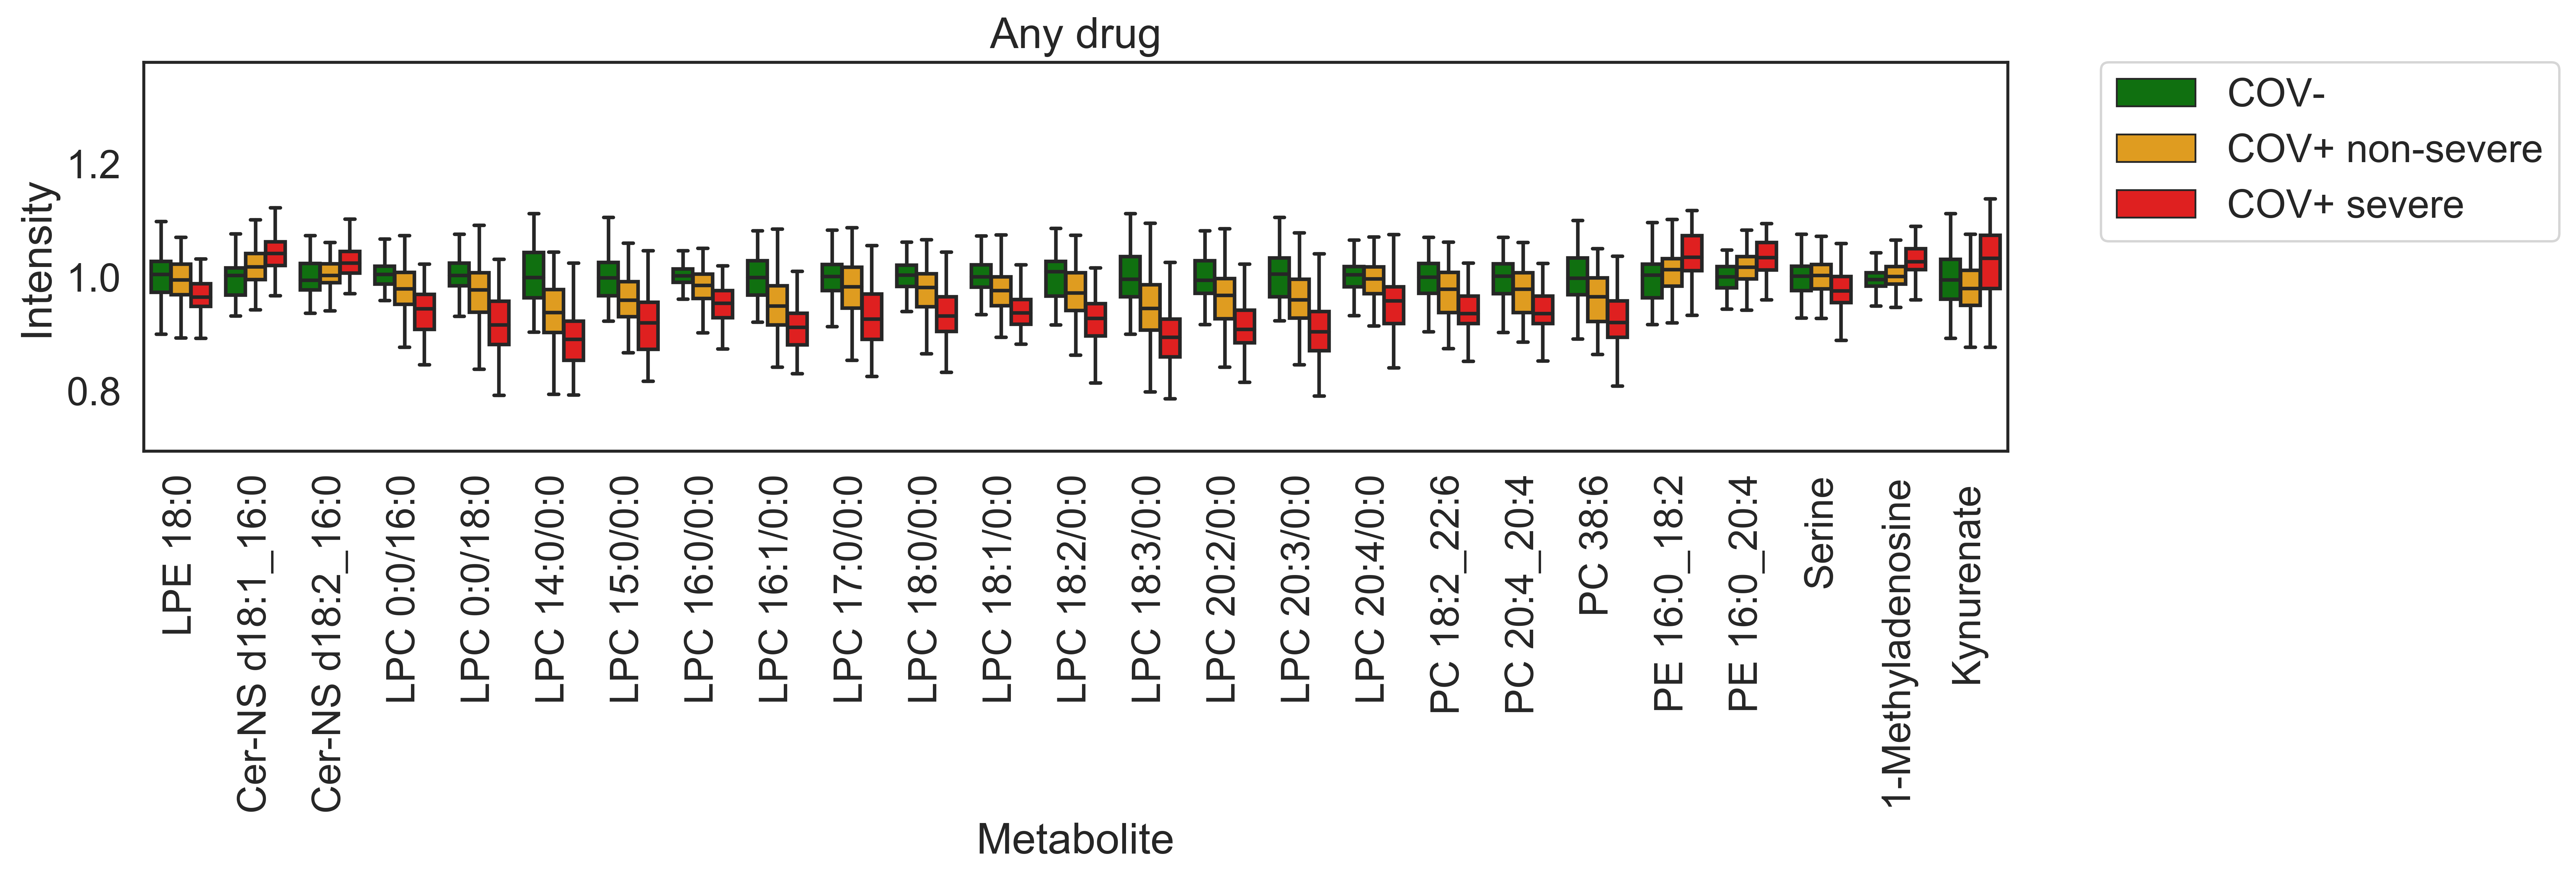

In [14]:
sb.axes_style("white")
sb.set(font_scale=1.5,font="Arial",style="white")
icu2Include = [1,0]
print(measurement_data.columns.values)
specialMapper = {"BMI":30,"Age":65}
default = .5
toTest = ["Diabetes","Acute renal failure","Chronic kidney disease","Cancer","BMI","Age","Smoker","Acute respiratory failure","BMI","Any drug"] 
toTest = ["Any drug"] 
cat2Plot = False
for col in toTest:
    cutoff = .5
    if col in specialMapper:
        cutoff = specialMapper[col]
    result = {}
    ind = 0
    for met in range(len(mol_names)):
        val = samp_int[:,met]
        indsToNorm = []
        norm = []
        for x,pat in zip(val,patient_ids):
            if pat in list(df.index.values):# and patient_ICU[pat] in icu2Include:
                comorb = df.at[pat,col]
                if not pd.isna(comorb):
                    if type(comorb) == type(""):
                        comorb = comorb.replace("<","").replace(">","")
                    if float(comorb) > -.5:
                        if comorb > cutoff:
                            comorb = True
                        else:
                            comorb = False
                         
                        covStatus = "COV-"
                        if patient_ICU[pat] < -.5 and comorb == cat2Plot:
                            norm.append(x)
                        if patient_ICU[pat] > -.5:
                            covStatus = "COV+ non-severe"
                            if patient_ICU[pat] > .5:
                                covStatus = "COV+ severe"
                        result[ind] = {"Intensity":x,"Metabolite":mol_names[met],"Patient Parameter":comorb,"COV":covStatus}
                        indsToNorm.append(ind)
                        ind += 1
        norm = np.mean(norm)
        for ind in indsToNorm:
            result[ind]["Intensity"] = result[ind]["Intensity"]/norm
            
    result = pd.DataFrame.from_dict(result,orient="index")
    result = result[result["Patient Parameter"] == cat2Plot]
    print(len(result)/25)
    
    plt.figure(figsize=(14,3))
    palette = {"COV-":"green","COV+ non-severe":"orange","COV+ severe":"red"}
    ax = sb.boxplot(data=result,x="Metabolite",y="Intensity",hue="COV",fliersize=0,palette=palette,hue_order=["COV-","COV+ non-severe","COV+ severe"])
    #sb.swarmplot(data=result,x="Metabolite",y="Intensity",hue="COV",dodge=True,palette=palette,hue_order=["COV+ non-severe","COV+ severe"])
    plt.title(col)
    handles, labels = ax.get_legend_handles_labels()
    l = plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xticks(rotation=90)


In [15]:
sb.axes_style("white")
sb.set(font_scale=1.5,font="Arial",style="white")
icu2Include = [1,0]
print(measurement_data.columns.values)
specialMapper = {"BMI":30,"Age":65}
default = .5
toTest = ["Diabetes","Acute renal failure","Chronic kidney disease","Cancer","BMI","Age","Smoker","Acute respiratory failure","BMI","Any drug"] 
toTest = ["Any drug"] 
cat2Plot = False
for col in toTest:
    cutoff = .5
    if col in specialMapper:
        cutoff = specialMapper[col]
    result = {}
    ind = 0
    for met in range(len(mol_names)):
        val = samp_int[:,met]
        indsToNorm = []
        norm = []
        for x,pat in zip(val,patient_ids):
            if pat in list(df.index.values):# and patient_ICU[pat] in icu2Include:
                comorb = df.at[pat,col]
                if not pd.isna(comorb):
                    if type(comorb) == type(""):
                        comorb = comorb.replace("<","").replace(">","")
                    if float(comorb) > -.5:
                        if comorb > cutoff:
                            comorb = True
                        else:
                            comorb = False
                         
                        covStatus = "COV-"
                        if patient_ICU[pat] < -.5 and comorb == cat2Plot:
                            norm.append(x)
                        if patient_ICU[pat] > -.5:
                            covStatus = "COV+ non-severe"
                            if patient_ICU[pat] > .5:
                                covStatus = "COV+ severe"
                        result[ind] = {"Intensity":x,"Metabolite":mol_names[met],"Patient Parameter":comorb,"COV":covStatus}
                        indsToNorm.append(ind)
                        ind += 1

            
    result = pd.DataFrame.from_dict(result,orient="index")
    result = result[result["Patient Parameter"] == cat2Plot]
  
    pvals = []
    for met in range(len(mol_names)):
        name = mol_names[met]
        args = []
        for cat in ["COV-","COV+ non-severe","COV+ severe"]:
            tmp = result[result["Metabolite"] == name]
            tmp = tmp[tmp["COV"] == cat]
            args.append(tmp["Intensity"].values)
        stat,p = welch_anova_np(*args)
        pvals.append(p)
    
    alpha = 0.05
    reject,pvals_corr,_,_ = multipletests(pvals,alpha,method="fdr_bh")

    for name,p in zip(mol_names,pvals_corr):
        print(name,p)


['CRP' 'D-dimer' 'Neutrophil %' 'CO2' 'Acute respiratory failure'
 'Diabetes' 'Acute renal failure' 'Chronic kidney disease' 'Cancer' 'BMI'
 'Age' 'Smoker' 'High/Low arterial pH' 'Neutrophil absolute'
 'Lymphocyte absolute' 'Lymphocyte %' 'Hydroxychloroquine' 'Chloroquine'
 'IL1b' 'IL10' 'IL6' 'RANTES' 'MIP1a' 'GMCSF' 'MCP1' 'IL15' 'HGF' 'VEGF'
 'IL1Ra' 'IL2R' 'MIG' 'IL8' 'Any drug']
LPE 18:0 1.2084952566441852e-06
Cer-NS d18:1_16:0 1.4400963974600209e-09
Cer-NS d18:2_16:0 3.6476590120681533e-06
LPC 0:0/16:0 1.961449338104675e-15
LPC 0:0/18:0 1.0019420962311497e-15
LPC 14:0/0:0 1.11649914068401e-17
LPC 15:0/0:0 3.5806508496607515e-14
LPC 16:0/0:0 1.3927303147619109e-14
LPC 16:1/0:0 1.238551888400427e-16
LPC 17:0/0:0 4.1937078350602605e-12
LPC 18:0/0:0 1.1764516601232131e-14
LPC 18:1/0:0 1.3927303147619109e-14
LPC 18:2/0:0 4.373651331039522e-14
LPC 18:3/0:0 6.294044127512361e-14
LPC 20:2/0:0 7.116702605254631e-16
LPC 20:3/0:0 5.455958256768246e-14
LPC 20:4/0:0 1.4558696762862778e-09
PC 